# EOS To MongDB

In [2]:
import pymongo
from pymongo import MongoClient
import glob
import datetime
import pprint
import codecs
import xmltodict
import gensim
import string 
from bson.objectid import ObjectId
from multiprocessing import Pool
import gzip

import pickle
from matplotlib import pyplot as plt
%matplotlib notebook
import dateparser
from datetime import datetime

import spacy
nlp = spacy.load('en')

In [3]:
def get_db(): 
    client = MongoClient('localhost:27017') 
    db = client.db 
    return db

In [19]:
%%time


eos_list = glob.glob('/home/sonic/sonic/EOS_DATA/english-2016-2017/*.xml')
eos_list.sort()
print (len(eos_list))

1425449
CPU times: user 3.34 s, sys: 408 ms, total: 3.75 s
Wall time: 3.83 s


In [65]:
%%time


def doc_generator(path):
    """
    generator function to read in documents from the file
    """
    
    for fname in path:
        with codecs.open(fname, encoding='utf_8') as doc_file:
            try:
                yield xmltodict.parse(doc_file.read())['Document']
            except Exception as e: 
                pass #print(e)
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [66]:

for item in enumerate(doc_generator(eos_list)):
    print(item)
    break

(0, OrderedDict([('Id', 'en_2015-11-01_3582b805fa6d2f5c12e6f0544beb325f07568'), ('SourceName', 'Prague Tribune'), ('CaptureDateTime', '22 Oct 2016 00:00:00'), ('PublicationDateTime', '22 Oct 2016 00:00:00'), ('Title', 'ISSUE #106'), ('TranslatedTitle', None), ('SourceCoverage', 'CZECH REPUBLIC'), ('Url', 'http://www.prague-tribune.cz/2004/10/2.htm'), ('Encoding', 'UTF-8'), ('Language', 'English'), ('SourceType', None), ('RobotName', 'prague-tribune'), ('Text', 'Written by: Anita Lišková\n\nFINANCE: Paying on credit\nMore and more Czechs are using the option of making purchases without paying the full amount up front, so this year installment plan sales will probably break last year’s record. This August Multiservis recorded a year-on-year increase in loans of 50%, and Cetelem recorded a 60% jump. These companies offer more affordable services, in particular expanding their portfolios. “We recorded significant growth in volume, especially thanks to new credit cards, another factor being

In [67]:
%%time


db = get_db()
print(type(db))
print(pymongo.version)
result = db.collection.insert_many(doc_generator(eos_list))

<class 'pymongo.database.Database'>
3.4.0
CPU times: user 4min 29s, sys: 25.3 s, total: 4min 54s
Wall time: 6min 28s


In [17]:
doc = db.collection.find_one({"Id": 'en_2015-12-06_7af651c04fecf6b6bda3f13ff6d901fb77d63af'})
# print(doc['tokens'])
print(doc)

{'TranslatedTitle': None, 'Id': 'en_2015-12-06_7af651c04fecf6b6bda3f13ff6d901fb77d63af', 'RobotName': 'abc10816', 'Title': 'James Lush', 'SourceName': 'ABC North West WA', '_id': ObjectId('595db173bb54594e576f8f05'), 'Text': 'James arrived in Perth from the UK back in 2004. It was meant to be for 2 years. It\'s now been 12. It says a lot for the life on offer here in the most remote city in the world.\n\nFor the past 25 years James has been working in the media. Originally doing all the "ugly unsociable" shifts at radio stations around the UK, before landing a day time show at the BBC in the South which he presented for over 5 years.\n\nSince arriving in Western Australia, James has spent time growing his own Media and Communication company, MC\'ing and facilitating events around the country and presenting a whole host of shows on 720 ABC Perth!\n\n"I\'m so lucky - I\'m passionate about what I do and I love the variety," James says.\n\n"I\'m nosy, inquisitive and I guess a bit cheeky a

In [3]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    return token.is_punct or token.is_space or (len(token.orth_) < 2)

In [4]:
with open('data/stopwords', encoding='utf-8') as fp:
    stopwords = fp.read().split('\n')
    
exclude = ["’s", "'s", "-PRON-", "'''", "``", "–", "‘a", "--", "..."]
stopwords.extend(exclude)
stopwords.extend(list(string.punctuation))
# print(stopwords)

In [5]:
# load the finished model from disk
bigram_model = gensim.models.Phrases.load('data/eos/ngram/bigram_model_%s' % 'all')
print('bigram loaded')

bigram loaded


In [11]:
%%time


def process_corpus(cursor):
    print ("Start documents process" + datetime.now().strftime("%H:%M:%S"))
    i = 0
    for doc in cursor:
        
        # print(doc)
        # lemmatize the text, removing punctuation and whitespace
        unigram_review = [token.lemma_ for token in nlp(doc['Text']) if not punct_space(token)]   
        # apply the first-order phrase models
        ngram_doc = bigram_model[unigram_review]
        # remove any remaining stopwords and exclude list
        ngram_doc = [term for term in ngram_doc if term not in stopwords]
        # Update document
        db.collection.update({'_id': ObjectId(doc['_id'])},
                             {'$set': {'tokens' : ngram_doc}}, upsert=False)
        i += 1
        if (i % 50000) == 0:
            print ("Process {} documents so far ".format(i) + datetime.now().strftime("%H:%M:%S"))
    



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 22.6 µs


In [8]:
def get_collection_cursor():
    db = get_db()
    return db.collection.find({}).batch_size(1000)

In [13]:
%%time


process_corpus(get_collection_cursor())

Start documents process15:32:40


/usr/local/lib/python3.5/dist-packages/gensim/models/phrases.py:274: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.


Process 50000 documents so far15:52:20
Process 100000 documents so far16:12:14
Process 150000 documents so far16:33:10
Process 200000 documents so far16:52:23
Process 250000 documents so far17:10:06
Process 300000 documents so far17:29:03
Process 350000 documents so far17:46:31
Process 400000 documents so far18:05:45
Process 450000 documents so far18:23:22
Process 500000 documents so far18:41:27
Process 550000 documents so far18:59:10
Process 600000 documents so far19:17:30
Process 650000 documents so far19:35:48
Process 700000 documents so far19:55:06
Process 750000 documents so far20:14:06
Process 800000 documents so far20:32:29
Process 850000 documents so far20:50:21
Process 900000 documents so far21:09:05
Process 950000 documents so far21:25:49
Process 1000000 documents so far21:42:38
Process 1050000 documents so far21:59:30
Process 1100000 documents so far22:17:05
Process 1150000 documents so far22:34:04
Process 1200000 documents so far22:51:38
Process 1250000 documents so far23:0

Counted 50000 documents so far 17:16:18
Counted 100000 documents so far 17:17:32
Counted 150000 documents so far 17:18:46
Counted 200000 documents so far 17:20:01
Counted 250000 documents so far 17:21:17
Counted 300000 documents so far 17:22:33
Counted 350000 documents so far 17:23:51
Counted 400000 documents so far 17:25:07
Counted 450000 documents so far 17:26:21
Counted 500000 documents so far 17:27:34
Counted 550000 documents so far 17:28:47
Counted 600000 documents so far 17:30:00
Counted 650000 documents so far 17:31:13
Counted 700000 documents so far 17:32:26
Counted 750000 documents so far 17:33:39
Counted 800000 documents so far 17:34:54
Counted 850000 documents so far 17:36:11
Counted 900000 documents so far 17:37:28
Counted 950000 documents so far 17:38:45
Counted 1000000 documents so far 17:40:04
Counted 1050000 documents so far 17:41:22
Counted 1100000 documents so far 17:42:41
Counted 1150000 documents so far 17:44:00
Counted 1200000 documents so far 17:45:21
Counted 1250

<IPython.core.display.Javascript object>


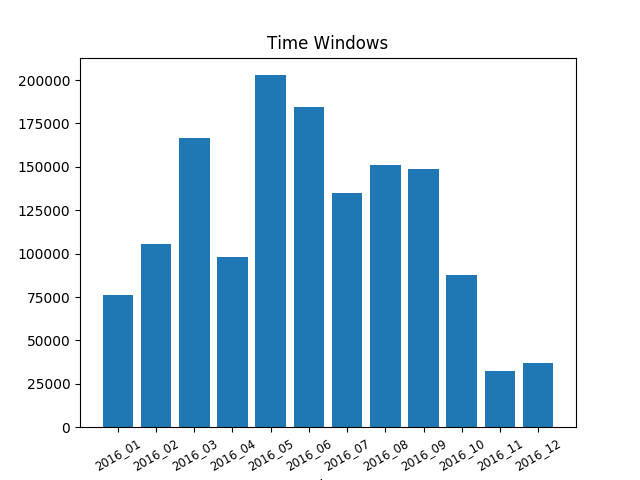

CPU times: user 36min 8s, sys: 2.68 s, total: 36min 11s
Wall time: 36min 16s


In [36]:
%%time

from operator import itemgetter

def corpus_info():

    cursor = get_collection_cursor()
    
    corpus = {}
    doc_count = 0
        
    for doc in cursor:        
        doc_date = dateparser.parse(doc['PublicationDateTime']).strftime('%Y_%m')        
        if (doc_date in corpus):
            corpus[doc_date].append(doc['Id'])   
        else:
            corpus[doc_date] = [doc['Id']]
            
        doc_count += 1       
        if (doc_count % 50000) == 0:
            print("Counted {} documents so far ".format(doc_count) + datetime.now().strftime("%H:%M:%S"))

    with open('data/eos/data_windows.pkl', 'wb') as f:
        pickle.dump(corpus, f)
    
    x = sorted(corpus) # time window
    y = [] # number of docs
    for item in x:
        y.append(len(corpus[item]))
        
    print(x)
    print(y)
    print('total number of documents: %d' % sum(y))

    plt.bar(range(len(y)), y, align='center')
    plt.xticks(range(len(x)), x, size='small')
    plt.title('Time Windows')
    plt.xlabel('Time')
    plt.xticks(rotation=30)
    plt.show()
    plt.savefig('data/eos/graphs/windows_corpus_info_2016_2017.png', bbox_inches='tight', dpi=800)

corpus_info()

In [4]:
def get_collection_cursor(ids):
    db = get_db()
    return db.collection.find({"Id": {'$in': ids }}).batch_size(1000)

In [5]:
def graph_corpus(corpus):
    x = sorted(corpus) # time window
    y = [] # number of docs
    for item in x:
        y.append(len(corpus[item]))
        
    print(x)
    print(y)
    print('total number of documents: %d' % sum(y))

    plt.bar(range(len(y)), y, align='center')
    plt.xticks(range(len(x)), x, size='small')
    plt.title('Time Windows')
    plt.xlabel('Time')
    plt.xticks(rotation=30)
    plt.show()
    plt.savefig('data/eos/graphs/windows_corpus_info_2016_2017.png', bbox_inches='tight', dpi=800)    

32146
118769
['2016_01', '2016_02', '2016_03', '2016_04', '2016_05', '2016_06', '2016_07', '2016_08', '2016_09', '2016_10', '2016_11', '2016_12']
[38073, 52718, 83384, 48961, 101402, 92269, 67597, 75472, 74372, 43858, 32146, 36870]
total number of documents: 747122


<IPython.core.display.Javascript object>


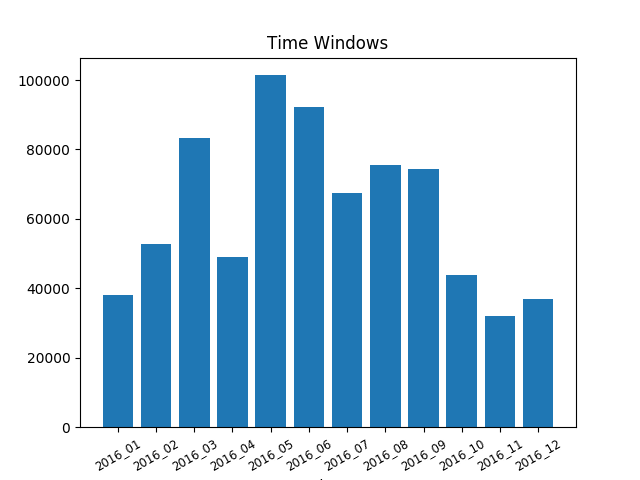

Processing 2016_06 documents so far 09:45:46
92269
Finished 2016_06 documents so far 09:46:28
Processing 2016_11 documents so far 09:46:28
32146
Finished 2016_11 documents so far 09:46:37
Processing 2016_12 documents so far 09:46:37
36870
Finished 2016_12 documents so far 09:46:48
Processing 2016_07 documents so far 09:46:48
67597
Finished 2016_07 documents so far 09:47:05
Processing 2016_04 documents so far 09:47:05
48961
Finished 2016_04 documents so far 09:47:19
Processing 2016_09 documents so far 09:47:19
74372
Finished 2016_09 documents so far 09:47:38
Processing 2016_05 documents so far 09:47:38
101402
Finished 2016_05 documents so far 09:48:04
Processing 2016_08 documents so far 09:48:04
75472
Finished 2016_08 documents so far 09:48:23
Processing 2016_01 documents so far 09:48:23
38073
Finished 2016_01 documents so far 09:48:34
Processing 2016_10 documents so far 09:48:34
43858
Finished 2016_10 documents so far 09:48:46
Processing 2016_02 documents so far 09:48:46
52718
Finished

In [6]:
%%time


import random

with open('data/eos/data_windows.pkl', 'rb') as f:
    corpus = pickle.load(f)
    
x = sorted(corpus) # time window
y = [] # number of docs
for item in x:
    y.append(len(corpus[item]))
    
print(min(y))
average = int(sum(y) / float(len(y)))
print(average)    

for window in corpus:
    random.shuffle(corpus[window])
    if (len(corpus[window]) > 75000 ):
        limit = int(len(corpus[window]) / 2)
        doc_ids = corpus[window][:limit]
        corpus[window] = doc_ids

bin_location = 'dynamic_nmf/data/windowbin/slices/text_total_windows_%s.gz'

graph_corpus(corpus)

f_all = gzip.open(bin_location  % 'all', 'w') 

for window in corpus:
    print("Processing %s documents so far " % format(window) + datetime.now().strftime("%H:%M:%S"))
    cursor = get_collection_cursor(corpus[window])
    
    doc_list = []
    for doc in cursor:
        doc_list.append(doc['Id'] + '\t' + u' '.join(doc['tokens']))
    print(len(doc_list))
    
    f = gzip.open(bin_location  % window, 'w')         
    f.write( '\n'.join( doc_list ).encode("utf-8") )
    f_all.write( '\n'.join( doc_list ).encode("utf-8") )
    f.close()
    print("Finished %s documents so far " % format(window) + datetime.now().strftime("%H:%M:%S"))
    
f_all.close()

In [1]:
length = [76147, 105437, 166768, 97922, 202805, 184538, 135195, 150944, 148744, 87716, 32146, 36870]

print(sum(length) / float(len(length)))

118769.33333333333
